# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. Let's have professor Raghavan introduce you to the problem statement:

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
1. Thumbs up:  Increase the volume
2. Thumbs down: Decrease the volume
3. Left swipe: 'Jump' backwards 10 seconds
4. Right swipe: 'Jump' forward 10 seconds
5. Stop: Pause the movie

 **Each video is a sequence of 30 frames (or images)**  

## Understanding the Dataset
> The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

> The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

 

> Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.



#### Dataset Link

https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

## Note: Kaggle GPU was used in this notebook


In [2]:
print('Using Kaggle GPU for this Project')

Using Kaggle GPU for this Project


## Checking Versions of the Library and GPU

In [5]:
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print()
print(f"Tensorflow Version: {tf.__version__}")
print()
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print()
print(f"Scikit-Learn {sk.__version__}")
print()
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")




Tensorflow Version: 2.6.4

Keras Version: 2.6.0

Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]

Pandas 1.3.5

Scikit-Learn 1.0.2

GPU is available


2022-12-14 07:19:18.510132: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 07:19:18.579191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 07:19:18.699842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 07:19:18.700582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Importing Basic Libaries

In [3]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import imageio.v2 as imageio
from skimage.transform import resize
import datetime
import os

In [4]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/kaggle/input/gesture-recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/gesture-recognition/Project_data/val.csv').readlines())
batch_size = 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

### Function for selecting number of frames

In [7]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


### Function to Normalize Image

In [8]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

### Function to Resize Image

In [9]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

### Function to Image Processing of Normalize and Resize

In [10]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

### Function to get Batch Data for all num-bacthes

In [11]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

### Generator Function Defination

In [12]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### Input of train and validation dataset

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = '/kaggle/input/gesture-recognition/Project_data/train'
val_path = '/kaggle/input/gesture-recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


#### Checking Train and validation batch shape

In [14]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
(64, 20, 100, 100, 3)
Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 64
(64, 20, 100, 100, 3)


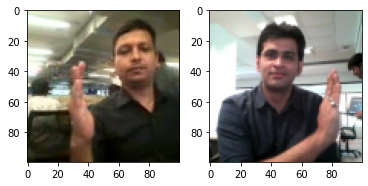

In [15]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[1,19,:,:,:])   
ax[1].imshow(sample_val_batch_data[63,19,:,:,:])
plt.show()

In [16]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## Modelling
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [18]:
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D

In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [21]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

## Model Callbacks Setup

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

# callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Model 1: 3D Convolution Model

In [35]:
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 12, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 6, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 6, 48, 48, 16)     64        
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 4, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 4, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 4, 23, 23, 32)     128       
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 2, 21, 21, 64)     553

2022-12-13 20:19:36.546497: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-12-13 20:19:38.637614: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


11/11 [==============================] - 136s 13s/step - loss: 1.5578 - categorical_accuracy: 0.4344 - val_loss: 4.8610 - val_categorical_accuracy: 0.2400
Epoch 2/20
11/11 [==============================] - 42s 4s/step - loss: 1.0151 - categorical_accuracy: 0.6166 - val_loss: 3.7469 - val_categorical_accuracy: 0.2656
Epoch 3/20
11/11 [==============================] - 40s 4s/step - loss: 1.0084 - categorical_accuracy: 0.5929 - val_loss: 3.1917 - val_categorical_accuracy: 0.1964
Epoch 4/20
11/11 [==============================] - 35s 3s/step - loss: 0.9876 - categorical_accuracy: 0.6309 - val_loss: 4.5909 - val_categorical_accuracy: 0.0938
Epoch 5/20
11/11 [==============================] - 29s 3s/step - loss: 0.8890 - categorical_accuracy: 0.6459 - val_loss: 3.7142 - val_categorical_accuracy: 0.1875
Epoch 6/20
11/11 [==============================] - 25s 3s/step - loss: 0.8540 - categorical_accuracy: 0.6555 - val_loss: 4.1598 - val_categorical_accuracy: 0.2500
Epoch 7/20
11/11 [=======

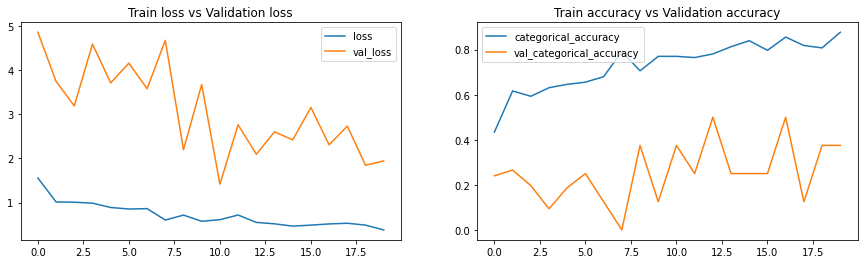

Max. Training Accuracy 0.8770053386688232
Max. Validaiton Accuracy 0.5


In [36]:
plotModelHistory(model1_history)

## Model 6: Switching Model architecture to Conv2D+LSTM

In [40]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model6.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 25, 25, 64)   

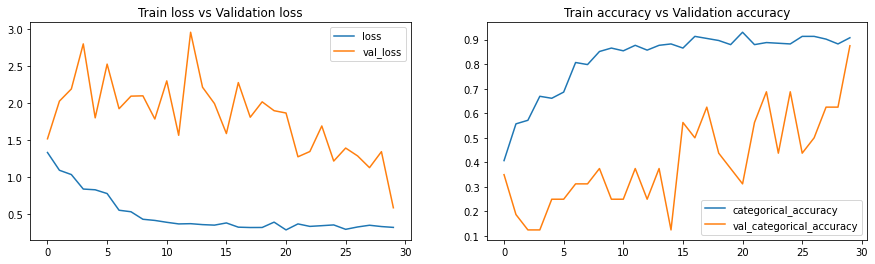

Max. Training Accuracy 0.9299719929695129
Max. Validaiton Accuracy 0.875


In [41]:
plotModelHistory(model6_history)

## Model 7: Transfer Learning (MobileNet) with LSTM

In [37]:
from tensorflow.keras.applications import MobileNet

In [38]:
mobilenet = MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model7.layers:
    layer.trainable = False

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(256))
model7.add(Dropout(0.2))

model7.add(Dense(256,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

model7.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)            

2022-12-14 07:29:17.675441: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-14 07:29:22.389012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


11/11 [==============================] - 163s 15s/step - loss: 1.3436 - categorical_accuracy: 0.4314 - val_loss: 1.1535 - val_categorical_accuracy: 0.4400
Epoch 2/30
11/11 [==============================] - 51s 5s/step - loss: 0.6762 - categorical_accuracy: 0.7866 - val_loss: 1.1742 - val_categorical_accuracy: 0.5938
Epoch 3/30
11/11 [==============================] - 50s 5s/step - loss: 0.5990 - categorical_accuracy: 0.7905 - val_loss: 0.9361 - val_categorical_accuracy: 0.6607
Epoch 4/30
11/11 [==============================] - 44s 4s/step - loss: 0.4483 - categorical_accuracy: 0.8112 - val_loss: 1.0002 - val_categorical_accuracy: 0.6250
Epoch 5/30
11/11 [==============================] - 37s 4s/step - loss: 0.3015 - categorical_accuracy: 0.9043 - val_loss: 1.5572 - val_categorical_accuracy: 0.5000
Epoch 6/30
11/11 [==============================] - 31s 3s/step - loss: 0.3075 - categorical_accuracy: 0.8995 - val_loss: 1.3435 - val_categorical_accuracy: 0.5000
Epoch 7/30
11/11 [=======

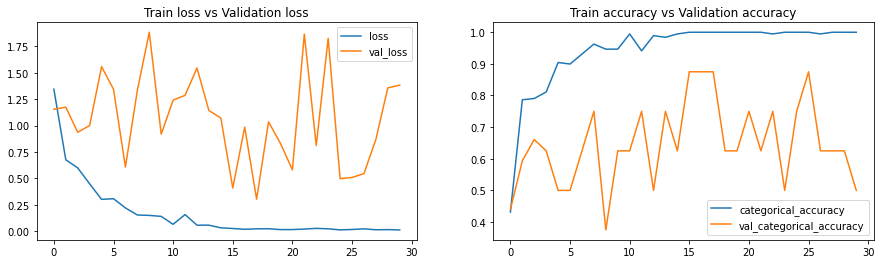

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.875


In [39]:
plotModelHistory(model7_history)

## Model 8: Transfer Learning (MobileNet) with GRU

In [41]:
from tensorflow.keras.applications import MobileNet

In [42]:
mobilenet = MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model8 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_GRU")

for layer in model8.layers:
    layer.trainable = False

model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model8.add(TimeDistributed(Flatten()))

model8.add(GRU(256))
model8.add(Dropout(0.2))

model8.add(Dense(256,activation='relu'))
model8.add(Dropout(0.2))

model8.add(Dense(5, activation='softmax'))

model8.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

model8_history = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
gru (GRU)                    (None, 256)               984576    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)             

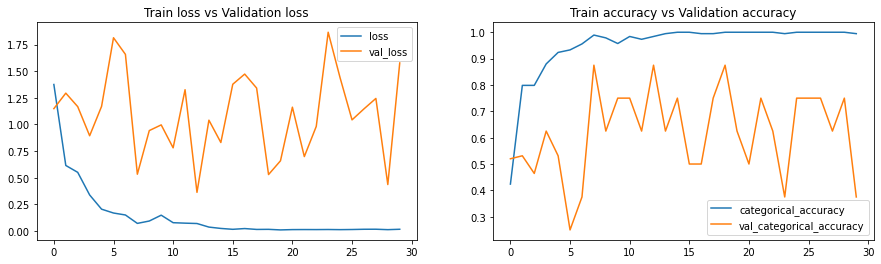

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.875


In [43]:
plotModelHistory(model8_history)

## Model 9: Transfer Learning (VGG16) with LSTM

In [45]:
from tensorflow.keras.applications import VGG16

In [45]:
vgg16net = VGG16(weights='imagenet', include_top=False)

n_frames = 15
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model9 = Sequential([
    TimeDistributed(vgg16net, input_shape=inputShape)
], name="vgg16net_lstm")

for layer in model9.layers:
    layer.trainable = False

model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model9.add(TimeDistributed(Flatten()))

model9.add(LSTM(256))
model9.add(Dropout(0.2))

model9.add(Dense(256,activation='relu'))
model9.add(Dropout(0.2))

model9.add(Dense(5, activation='softmax'))

model9.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

model9_history = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

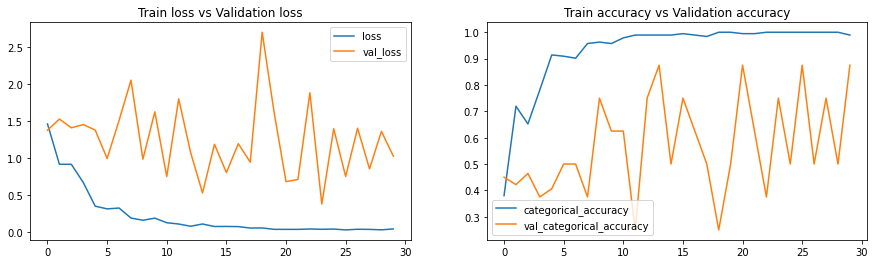

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.875


In [47]:
plotModelHistory(model9_history)

## Model 10: Transfer Learning (ResNet) with GRU

In [49]:
from tensorflow.keras.applications import ResNet50

restnet = ResNet50(weights='imagenet', include_top=False)

n_frames = 15
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model10 = Sequential([
    TimeDistributed(restnet, input_shape=inputShape)
], name="restnet_gru")

for layer in model10.layers:
    layer.trainable = False

model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model10.add(TimeDistributed(Flatten()))

model10.add(GRU(256))
model10.add(Dropout(0.2))

model10.add(Dense(256,activation='relu'))
model10.add(Dropout(0.2))

model10.add(Dense(5, activation='softmax'))

model10.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

model10_history = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

94781440/94765736 [==============================] - 0s 0us/step
Model: "restnet_gru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 15, 4, 4, 2048)    23587712  
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 4, 4, 2048)    8192      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 2, 2, 2048)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 8192)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               6489600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
________________________________________________________

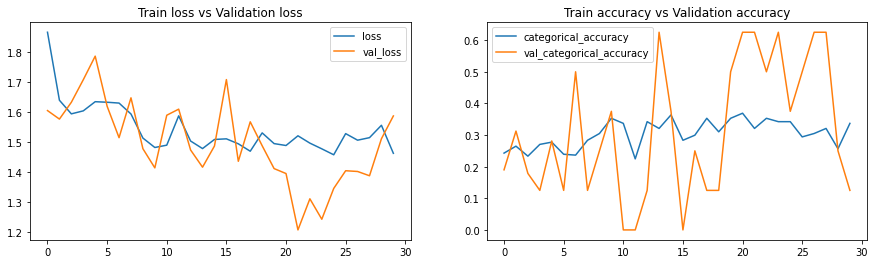

Max. Training Accuracy 0.3689839541912079
Max. Validaiton Accuracy 0.625


In [50]:
plotModelHistory(model10_history)

## Trying Various Batch Sizes and frames size

### Model 2, 3 and 4 combined into function

In [51]:
#write your model here
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 11, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 48, 48, 16)     64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 4, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 23, 23, 32)     128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 21, 21, 64)     5

In [60]:
def testBatchSize(batch_size, n_frames):
    img_tensor = getImgTensor(n_frames)
    print("Using frames as", img_tensor[0])
    global callbacks_list
    num_epochs = 3
    train_generator = generator(train_path, train_doc, batch_size, img_tensor)
    val_generator = generator(val_path, val_doc, batch_size, img_tensor)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = defineModel(img_tensor)
    model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    plotModelHistory(model_history)
    
    

Using frames as [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
Epoch 1/3
11/11 [==============================] - 214s 21s/step - loss: 1.4623 - categorical_accuracy: 0.4389 - val_loss: 3.5417 - val_categorical_accuracy: 0.2500
Epoch 2/3
11/11 [==============================] - 92s 9s/step - loss: 0.9492 - categorical_accuracy: 0.6798 - val_loss: 2.2305 - val_categorical_accuracy: 0.2344
Epoch 3/3
11/11 [==============================] - 91s 9s/step - loss: 0.9189 - categorical_accuracy: 0.6759 - val_loss: 2.4466 - val_categorical_accuracy: 0.2143


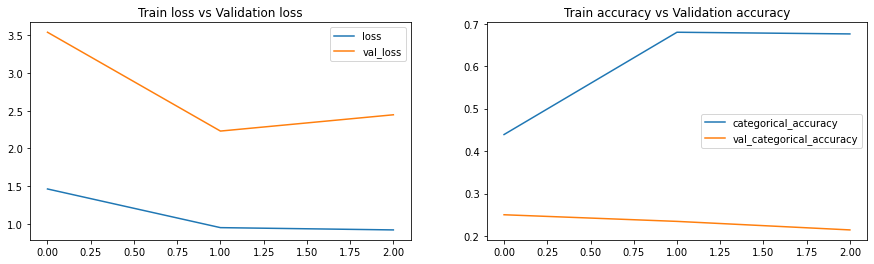

Max. Training Accuracy 0.6798418760299683
Max. Validaiton Accuracy 0.25


In [61]:
testBatchSize(batch_size=64, n_frames=30)

Using frames as [ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/3
21/21 [==============================] - 110s 5s/step - loss: 1.5280 - categorical_accuracy: 0.4480 - val_loss: 3.4538 - val_categorical_accuracy: 0.1900
Epoch 2/3
21/21 [==============================] - 66s 3s/step - loss: 0.9317 - categorical_accuracy: 0.6356 - val_loss: 4.9008 - val_categorical_accuracy: 0.0625
Epoch 3/3
21/21 [==============================] - 51s 3s/step - loss: 0.9661 - categorical_accuracy: 0.6511 - val_loss: 3.2094 - val_categorical_accuracy: 0.2500


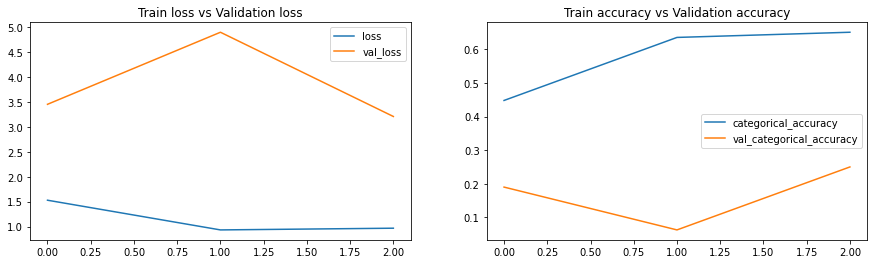

Max. Training Accuracy 0.6510538458824158
Max. Validaiton Accuracy 0.25


In [62]:
testBatchSize(batch_size=32, n_frames=16)

In [1]:
testBatchSize(batch_size=10, n_frames=20)

NameError: name 'testBatchSize' is not defined

### batch size is not impacting training time but number of frames is impacting

## Model 5: Frames-20, Same pooling in Conv3D layer

In [58]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model5 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")
model5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 10, 50, 50, 16)    64        
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 5, 25, 25, 32)     128       
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 5, 25, 25, 64)     553

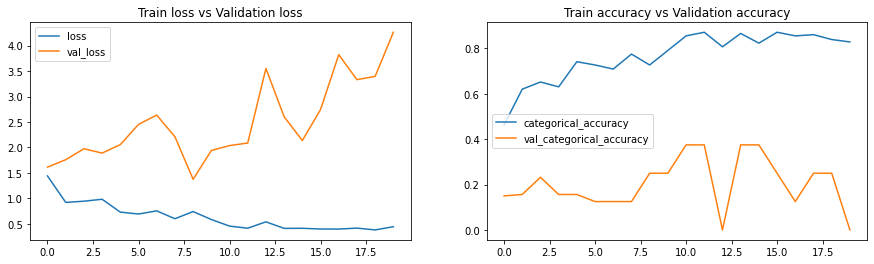

Max. Training Accuracy 0.8716577291488647
Max. Validaiton Accuracy 0.375


In [59]:
plotModelHistory(model5_history)

## Best Model Selection

In [29]:
from tensorflow.keras.applications import MobileNet

In [30]:
mobilenet = MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_final = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model_final.layers:
    layer.trainable = False

model_final.add(TimeDistributed(BatchNormalization()))
model_final.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model_final.add(TimeDistributed(Flatten()))

model_final.add(LSTM(256))
model_final.add(Dropout(0.2))

model_final.add(Dense(256,activation='relu'))
model_final.add(Dropout(0.2))

model_final.add(Dense(5, activation='softmax'))

model_final.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_final.summary())

Model: "mobilenet_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)            

In [31]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
model_final_history = model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - 170s 17s/step - loss: 1.3809 - categorical_accuracy: 0.4193 - val_loss: 1.1406 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2022-12-1413_15_50.624541/model-00001-1.38089-0.41931-1.14063-0.54000.h5
Epoch 2/30
11/11 [==============================] - 65s 6s/step - loss: 0.6864 - categorical_accuracy: 0.7668 - val_loss: 1.2096 - val_categorical_accuracy: 0.5312

Epoch 00002: saving model to model_init_2022-12-1413_15_50.624541/model-00002-0.68638-0.76680-1.20963-0.53125.h5
Epoch 3/30
11/11 [==============================] - 54s 5s/step - loss: 0.5662 - categorical_accuracy: 0.7945 - val_loss: 1.1082 - val_categorical_accuracy: 0.5179

Epoch 00003: saving model to model_init_2022-12-1413_15_50.624541/model-00003-0.56616-0.79447-1.10824-0.51786.h5
Epoch 4/30
11/11 [==============================] - 47s 5s/step - loss: 0.4391

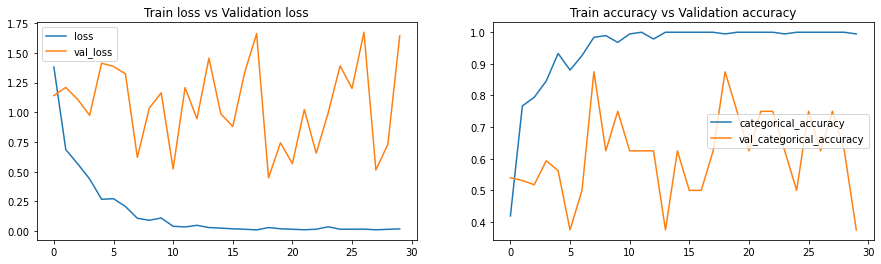

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.875


In [34]:
plotModelHistory(model_final_history)

## final model link : 